In [8]:
import argparse, os, math
import numpy as np
from scipy.stats import entropy


import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import inception_v3
#[?]from torchvision.transforms import ToTensor

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

from tqdm.notebook import tqdm, trange

In [9]:
!nvidia-smi

Wed Jun 14 16:04:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3E:00.0 Off |                  N/A |
| 28%   32C    P8     8W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
from PIL import Image

# Open an image file
img = Image.open('./data/celebA/img_align_celeba/dummy/141818.jpg')

# Print out the size of the image
print(img.size)


(178, 218)


In [32]:
n_epochs = 250
batch_size = 32
lr = 0.0002
b1, b2 = 0.5, 0.999
latent_dim = 100
img_size = 64
channels = 3
sample_interval = 400

In [33]:
cuda = True if torch.cuda.is_available() else False

In [34]:
cuda

True

In [35]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [36]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [37]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


In [38]:
# adversarial loss
adv_loss = torch.nn.BCELoss()

In [39]:
g = Generator()
d = Discriminator()

In [40]:
if cuda:
    g.cuda()
    d.cuda()
    adv_loss.cuda()

In [41]:
g.apply(weights_init_normal)
d.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [42]:
from torch.utils.data import Dataset
from PIL import Image
import glob

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.list_of_files = glob.glob(root_dir + '/*.jpg')
        self.list_of_files = self.list_of_files[:len(self.list_of_files) // 2]

    def __len__(self):
        return len(self.list_of_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.list_of_files[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image


In [43]:
transform = transforms.Compose(
    [transforms.CenterCrop(178),
     transforms.Resize((64,64)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

# processing 4 images at once. *adjustable*
batch_size = 128

# set trainset: loading CIFAR-10, apply previously defined transform function
dataset = CelebADataset(root_dir='./data/celebA/img_align_celeba/dummy', transform=transform)

# set trainloader: put training dataset to DataLoader
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


In [44]:
optimizer_G = torch.optim.Adam(g.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(d.parameters(), lr=lr, betas=(b1, b2))

In [45]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [46]:
device = torch.device('cuda')

In [47]:
#!pip install pytorch-ignite

In [52]:
from ignite.metrics import InceptionScore
from ignite.engine import Engine, Events

def eval_step(engine, batch):
    batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
    return batch


evaluator = Engine(eval_step)
inception_score = InceptionScore()
inception_score.attach(evaluator, "is")



In [53]:
is_history = []
g_loss_history = []
d_loss_history = []

for epoch in tqdm(range(n_epochs)):
    for i, imgs in tqdm(enumerate(dataloader)):

        # Adversarial ground truths
        valid = torch.ones((imgs.shape[0], 1), dtype=torch.float32, device=device)
        fake = torch.zeros((imgs.shape[0], 1), dtype=torch.float32, device=device)

        # Configure input
        real_imgs = imgs.type(Tensor)       

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        #torch.manual_seed(42)
        z = torch.randn((imgs.shape[0], latent_dim), device=device)

        # Generate a batch of images
        gen_imgs = g(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adv_loss(d(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adv_loss(d(real_imgs), valid)
        fake_loss = adv_loss(d(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            g_loss_history.append(g_loss.item())
            d_loss_history.append(d_loss.item())

    save_image(gen_imgs.data[:1], "images_celebA_DCGAN/%d.png" % epoch, nrow=1, normalize=True)
    state = evaluator.run([gen_imgs.data])
    is_history.append(state.metrics["is"])
    print("Epoch %d, Inception Score: %f" % (epoch, state.metrics["is"]))

    

  0%|          | 0/250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0, Inception Score: 2.771332


0it [00:00, ?it/s]

Epoch 1, Inception Score: 2.554798


0it [00:00, ?it/s]

Epoch 2, Inception Score: 2.354357


0it [00:00, ?it/s]

Epoch 3, Inception Score: 2.948918


0it [00:00, ?it/s]

Epoch 4, Inception Score: 2.729838


0it [00:00, ?it/s]

Epoch 5, Inception Score: 2.660047


0it [00:00, ?it/s]

Epoch 6, Inception Score: 2.579596


0it [00:00, ?it/s]

Epoch 7, Inception Score: 2.207371


0it [00:00, ?it/s]

Epoch 8, Inception Score: 3.010385


0it [00:00, ?it/s]

Epoch 9, Inception Score: 2.652029


0it [00:00, ?it/s]

Epoch 10, Inception Score: 2.571814


0it [00:00, ?it/s]

Epoch 11, Inception Score: 2.677975


0it [00:00, ?it/s]

Epoch 12, Inception Score: 2.232841


0it [00:00, ?it/s]

Epoch 13, Inception Score: 2.428713


0it [00:00, ?it/s]

Epoch 14, Inception Score: 2.420072


0it [00:00, ?it/s]

Epoch 15, Inception Score: 2.740436


0it [00:00, ?it/s]

Epoch 16, Inception Score: 2.213635


0it [00:00, ?it/s]

Epoch 17, Inception Score: 2.740629


0it [00:00, ?it/s]

Epoch 18, Inception Score: 2.250663


0it [00:00, ?it/s]

Epoch 19, Inception Score: 2.061052


0it [00:00, ?it/s]

Epoch 20, Inception Score: 2.043742


0it [00:00, ?it/s]

Epoch 21, Inception Score: 2.836231


0it [00:00, ?it/s]

Epoch 22, Inception Score: 2.296126


0it [00:00, ?it/s]

Epoch 23, Inception Score: 2.215825


0it [00:00, ?it/s]

Epoch 24, Inception Score: 2.547306


0it [00:00, ?it/s]

Epoch 25, Inception Score: 2.141237


0it [00:00, ?it/s]

Epoch 26, Inception Score: 2.669474


0it [00:00, ?it/s]

Epoch 27, Inception Score: 2.196563


0it [00:00, ?it/s]

Epoch 28, Inception Score: 2.384228


0it [00:00, ?it/s]

Epoch 29, Inception Score: 2.543652


0it [00:00, ?it/s]

Epoch 30, Inception Score: 2.044776


0it [00:00, ?it/s]

Epoch 31, Inception Score: 2.221031


0it [00:00, ?it/s]

Epoch 32, Inception Score: 2.332866


0it [00:00, ?it/s]

Epoch 33, Inception Score: 2.367813


0it [00:00, ?it/s]

Epoch 34, Inception Score: 2.443727


0it [00:00, ?it/s]

Epoch 35, Inception Score: 2.175242


0it [00:00, ?it/s]

Epoch 36, Inception Score: 1.829460


0it [00:00, ?it/s]

Epoch 37, Inception Score: 2.439535


0it [00:00, ?it/s]

Epoch 38, Inception Score: 2.535339


0it [00:00, ?it/s]

Epoch 39, Inception Score: 2.256489


0it [00:00, ?it/s]

Epoch 40, Inception Score: 2.706961


0it [00:00, ?it/s]

Epoch 41, Inception Score: 2.063540


0it [00:00, ?it/s]

Epoch 42, Inception Score: 2.127748


0it [00:00, ?it/s]

Epoch 43, Inception Score: 1.920242


0it [00:00, ?it/s]

Epoch 44, Inception Score: 2.211067


0it [00:00, ?it/s]

Epoch 45, Inception Score: 2.432596


0it [00:00, ?it/s]

Epoch 46, Inception Score: 2.110168


0it [00:00, ?it/s]

Epoch 47, Inception Score: 2.578357


0it [00:00, ?it/s]

Epoch 48, Inception Score: 2.314728


0it [00:00, ?it/s]

Epoch 49, Inception Score: 2.082919


0it [00:00, ?it/s]

Epoch 50, Inception Score: 2.218301


0it [00:00, ?it/s]

Epoch 51, Inception Score: 2.357820


0it [00:00, ?it/s]

Epoch 52, Inception Score: 2.352305


0it [00:00, ?it/s]

Epoch 53, Inception Score: 2.210750


0it [00:00, ?it/s]

Epoch 54, Inception Score: 2.252977


0it [00:00, ?it/s]

Epoch 55, Inception Score: 2.114505


0it [00:00, ?it/s]

Epoch 56, Inception Score: 2.321952


0it [00:00, ?it/s]

Epoch 57, Inception Score: 2.300707


0it [00:00, ?it/s]

Epoch 58, Inception Score: 2.543013


0it [00:00, ?it/s]

Epoch 59, Inception Score: 2.238403


0it [00:00, ?it/s]

Epoch 60, Inception Score: 2.141908


0it [00:00, ?it/s]

Epoch 61, Inception Score: 2.155285


0it [00:00, ?it/s]

Epoch 62, Inception Score: 2.239804


0it [00:00, ?it/s]

Epoch 63, Inception Score: 2.108423


0it [00:00, ?it/s]

Epoch 64, Inception Score: 2.444559


0it [00:00, ?it/s]

Epoch 65, Inception Score: 2.336951


0it [00:00, ?it/s]

Epoch 66, Inception Score: 2.469992


0it [00:00, ?it/s]

Epoch 67, Inception Score: 2.330081


0it [00:00, ?it/s]

Epoch 68, Inception Score: 2.914839


0it [00:00, ?it/s]

Epoch 69, Inception Score: 2.228298


0it [00:00, ?it/s]

Epoch 70, Inception Score: 2.141479


0it [00:00, ?it/s]

Epoch 71, Inception Score: 2.304462


0it [00:00, ?it/s]

Epoch 72, Inception Score: 2.373372


0it [00:00, ?it/s]

Epoch 73, Inception Score: 2.680301


0it [00:00, ?it/s]

Epoch 74, Inception Score: 2.523524


0it [00:00, ?it/s]

Epoch 75, Inception Score: 2.327571


0it [00:00, ?it/s]

Epoch 76, Inception Score: 2.792044


0it [00:00, ?it/s]

Epoch 77, Inception Score: 2.686404


0it [00:00, ?it/s]

Epoch 78, Inception Score: 2.422133


0it [00:00, ?it/s]

Epoch 79, Inception Score: 2.565405


0it [00:00, ?it/s]

Epoch 80, Inception Score: 2.629589


0it [00:00, ?it/s]

Epoch 81, Inception Score: 2.751260


0it [00:00, ?it/s]

Epoch 82, Inception Score: 2.481791


0it [00:00, ?it/s]

Epoch 83, Inception Score: 2.218214


0it [00:00, ?it/s]

Epoch 84, Inception Score: 2.389929


0it [00:00, ?it/s]

Epoch 85, Inception Score: 2.321234


0it [00:00, ?it/s]

Epoch 86, Inception Score: 2.249428


0it [00:00, ?it/s]

Epoch 87, Inception Score: 2.194560


0it [00:00, ?it/s]

Epoch 88, Inception Score: 2.159917


0it [00:00, ?it/s]

Epoch 89, Inception Score: 2.424128


0it [00:00, ?it/s]

Epoch 90, Inception Score: 2.621572


0it [00:00, ?it/s]

Epoch 91, Inception Score: 2.369494


0it [00:00, ?it/s]

Epoch 92, Inception Score: 3.418515


0it [00:00, ?it/s]

Epoch 93, Inception Score: 2.151112


0it [00:00, ?it/s]

Epoch 94, Inception Score: 2.495129


0it [00:00, ?it/s]

Epoch 95, Inception Score: 2.430890


0it [00:00, ?it/s]

Epoch 96, Inception Score: 2.117846


0it [00:00, ?it/s]

Epoch 97, Inception Score: 1.893382


0it [00:00, ?it/s]

Epoch 98, Inception Score: 2.432241


0it [00:00, ?it/s]

Epoch 99, Inception Score: 2.516514


0it [00:00, ?it/s]

Epoch 100, Inception Score: 2.585923


0it [00:00, ?it/s]

Epoch 101, Inception Score: 2.302725


0it [00:00, ?it/s]

Epoch 102, Inception Score: 2.134050


0it [00:00, ?it/s]

Epoch 103, Inception Score: 2.744828


0it [00:00, ?it/s]

Epoch 104, Inception Score: 2.110298


0it [00:00, ?it/s]

Epoch 105, Inception Score: 2.678066


0it [00:00, ?it/s]

Epoch 106, Inception Score: 2.376642


0it [00:00, ?it/s]

Epoch 107, Inception Score: 2.199373


0it [00:00, ?it/s]

Epoch 108, Inception Score: 2.235137


0it [00:00, ?it/s]

Epoch 109, Inception Score: 2.763571


0it [00:00, ?it/s]

Epoch 110, Inception Score: 2.212816


0it [00:00, ?it/s]

Epoch 111, Inception Score: 2.614115


0it [00:00, ?it/s]

Epoch 112, Inception Score: 2.343993


0it [00:00, ?it/s]

Epoch 113, Inception Score: 2.495578


0it [00:00, ?it/s]

Epoch 114, Inception Score: 2.529037


0it [00:00, ?it/s]

Epoch 115, Inception Score: 2.805626


0it [00:00, ?it/s]

Epoch 116, Inception Score: 2.495093


0it [00:00, ?it/s]

Epoch 117, Inception Score: 2.463570


0it [00:00, ?it/s]

Epoch 118, Inception Score: 2.440922


0it [00:00, ?it/s]

Epoch 119, Inception Score: 2.153326


0it [00:00, ?it/s]

Epoch 120, Inception Score: 2.953792


0it [00:00, ?it/s]

Epoch 121, Inception Score: 2.292846


0it [00:00, ?it/s]

Epoch 122, Inception Score: 2.261713


0it [00:00, ?it/s]

Epoch 123, Inception Score: 2.386659


0it [00:00, ?it/s]

Epoch 124, Inception Score: 2.858011


0it [00:00, ?it/s]

Epoch 125, Inception Score: 2.521820


0it [00:00, ?it/s]

Epoch 126, Inception Score: 2.387582


0it [00:00, ?it/s]

Epoch 127, Inception Score: 2.431603


0it [00:00, ?it/s]

Epoch 128, Inception Score: 2.108423


0it [00:00, ?it/s]

Epoch 129, Inception Score: 2.994725


0it [00:00, ?it/s]

Epoch 130, Inception Score: 1.992181


0it [00:00, ?it/s]

Epoch 131, Inception Score: 2.364590


0it [00:00, ?it/s]

Epoch 132, Inception Score: 2.383024


0it [00:00, ?it/s]

Epoch 133, Inception Score: 2.410697


0it [00:00, ?it/s]

Epoch 134, Inception Score: 2.723340


0it [00:00, ?it/s]

Epoch 135, Inception Score: 2.627390


0it [00:00, ?it/s]

Epoch 136, Inception Score: 2.433980


0it [00:00, ?it/s]

Epoch 137, Inception Score: 2.278391


0it [00:00, ?it/s]

Epoch 138, Inception Score: 2.377983


0it [00:00, ?it/s]

Epoch 139, Inception Score: 2.081837


0it [00:00, ?it/s]

Epoch 140, Inception Score: 2.530918


0it [00:00, ?it/s]

Epoch 141, Inception Score: 2.371524


0it [00:00, ?it/s]

Epoch 142, Inception Score: 2.355316


0it [00:00, ?it/s]

Epoch 143, Inception Score: 2.213558


0it [00:00, ?it/s]

Epoch 144, Inception Score: 2.414348


0it [00:00, ?it/s]

Epoch 145, Inception Score: 2.488161


0it [00:00, ?it/s]

Epoch 146, Inception Score: 2.174011


0it [00:00, ?it/s]

Epoch 147, Inception Score: 2.080997


0it [00:00, ?it/s]

Epoch 148, Inception Score: 2.278019


0it [00:00, ?it/s]

Epoch 149, Inception Score: 2.217986


0it [00:00, ?it/s]

Epoch 150, Inception Score: 2.611006


0it [00:00, ?it/s]

Epoch 151, Inception Score: 2.420804


0it [00:00, ?it/s]

Epoch 152, Inception Score: 2.242467


0it [00:00, ?it/s]

Epoch 153, Inception Score: 2.598581


0it [00:00, ?it/s]

Epoch 154, Inception Score: 1.938635


0it [00:00, ?it/s]

Epoch 155, Inception Score: 2.124326


0it [00:00, ?it/s]

Epoch 156, Inception Score: 2.356999


0it [00:00, ?it/s]

Epoch 157, Inception Score: 2.794444


0it [00:00, ?it/s]

Epoch 158, Inception Score: 2.234228


0it [00:00, ?it/s]

Epoch 159, Inception Score: 2.140898


0it [00:00, ?it/s]

Epoch 160, Inception Score: 2.619961


0it [00:00, ?it/s]

Epoch 161, Inception Score: 2.943342


0it [00:00, ?it/s]

Epoch 162, Inception Score: 2.262962


0it [00:00, ?it/s]

Epoch 163, Inception Score: 2.415483


0it [00:00, ?it/s]

Epoch 164, Inception Score: 2.331848


0it [00:00, ?it/s]

Epoch 165, Inception Score: 2.610030


0it [00:00, ?it/s]

Epoch 166, Inception Score: 2.564335


0it [00:00, ?it/s]

Epoch 167, Inception Score: 2.405182


0it [00:00, ?it/s]

Epoch 168, Inception Score: 2.530837


0it [00:00, ?it/s]

Epoch 169, Inception Score: 2.143699


0it [00:00, ?it/s]

Epoch 170, Inception Score: 2.057848


0it [00:00, ?it/s]

Epoch 171, Inception Score: 2.244320


0it [00:00, ?it/s]

Epoch 172, Inception Score: 2.254743


0it [00:00, ?it/s]

Epoch 173, Inception Score: 2.442651


0it [00:00, ?it/s]

Epoch 174, Inception Score: 2.258443


0it [00:00, ?it/s]

Epoch 175, Inception Score: 2.464790


0it [00:00, ?it/s]

Epoch 176, Inception Score: 2.305329


0it [00:00, ?it/s]

Epoch 177, Inception Score: 2.216277


0it [00:00, ?it/s]

Epoch 178, Inception Score: 2.422049


0it [00:00, ?it/s]

Epoch 179, Inception Score: 2.356424


0it [00:00, ?it/s]

Epoch 180, Inception Score: 1.960456


0it [00:00, ?it/s]

Epoch 181, Inception Score: 1.892153


0it [00:00, ?it/s]

Epoch 182, Inception Score: 2.020536


0it [00:00, ?it/s]

Epoch 183, Inception Score: 2.072175


0it [00:00, ?it/s]

Epoch 184, Inception Score: 2.225484


0it [00:00, ?it/s]

Epoch 185, Inception Score: 2.359185


0it [00:00, ?it/s]

Epoch 186, Inception Score: 2.524406


0it [00:00, ?it/s]

Epoch 187, Inception Score: 2.655479


0it [00:00, ?it/s]

Epoch 188, Inception Score: 2.181291


0it [00:00, ?it/s]

Epoch 189, Inception Score: 2.129911


0it [00:00, ?it/s]

Epoch 190, Inception Score: 2.550797


0it [00:00, ?it/s]

Epoch 191, Inception Score: 2.222045


0it [00:00, ?it/s]

Epoch 192, Inception Score: 2.277898


0it [00:00, ?it/s]

Epoch 193, Inception Score: 2.558718


0it [00:00, ?it/s]

Epoch 194, Inception Score: 2.484087


0it [00:00, ?it/s]

Epoch 195, Inception Score: 2.104822


0it [00:00, ?it/s]

Epoch 196, Inception Score: 2.456461


0it [00:00, ?it/s]

Epoch 197, Inception Score: 2.441395


0it [00:00, ?it/s]

Epoch 198, Inception Score: 2.104516


0it [00:00, ?it/s]

Epoch 199, Inception Score: 2.249727


0it [00:00, ?it/s]

Epoch 200, Inception Score: 2.339936


0it [00:00, ?it/s]

Epoch 201, Inception Score: 2.228100


0it [00:00, ?it/s]

Epoch 202, Inception Score: 1.794754


0it [00:00, ?it/s]

Epoch 203, Inception Score: 2.129262


0it [00:00, ?it/s]

Epoch 204, Inception Score: 1.873592


0it [00:00, ?it/s]

Epoch 205, Inception Score: 2.012761


0it [00:00, ?it/s]

Epoch 206, Inception Score: 2.243978


0it [00:00, ?it/s]

Epoch 207, Inception Score: 2.322808


0it [00:00, ?it/s]

Epoch 208, Inception Score: 2.314142


0it [00:00, ?it/s]

Epoch 209, Inception Score: 2.166674


0it [00:00, ?it/s]

Epoch 210, Inception Score: 2.214693


0it [00:00, ?it/s]

Epoch 211, Inception Score: 2.317183


0it [00:00, ?it/s]

Epoch 212, Inception Score: 1.926843


0it [00:00, ?it/s]

Epoch 213, Inception Score: 2.418644


0it [00:00, ?it/s]

Epoch 214, Inception Score: 2.252399


0it [00:00, ?it/s]

Epoch 215, Inception Score: 2.300620


0it [00:00, ?it/s]

Epoch 216, Inception Score: 2.133601


0it [00:00, ?it/s]

Epoch 217, Inception Score: 2.275578


0it [00:00, ?it/s]

Epoch 218, Inception Score: 2.496219


0it [00:00, ?it/s]

Epoch 219, Inception Score: 2.192249


0it [00:00, ?it/s]

Epoch 220, Inception Score: 2.447209


0it [00:00, ?it/s]

Epoch 221, Inception Score: 2.461258


0it [00:00, ?it/s]

Epoch 222, Inception Score: 2.188781


0it [00:00, ?it/s]

Epoch 223, Inception Score: 1.899364


0it [00:00, ?it/s]

Epoch 224, Inception Score: 2.152009


0it [00:00, ?it/s]

Epoch 225, Inception Score: 2.502446


0it [00:00, ?it/s]

Epoch 226, Inception Score: 2.334575


0it [00:00, ?it/s]

Epoch 227, Inception Score: 2.222917


0it [00:00, ?it/s]

Epoch 228, Inception Score: 2.556319


0it [00:00, ?it/s]

Epoch 229, Inception Score: 2.282471


0it [00:00, ?it/s]

Epoch 230, Inception Score: 2.301030


0it [00:00, ?it/s]

Epoch 231, Inception Score: 2.334109


0it [00:00, ?it/s]

Epoch 232, Inception Score: 2.388350


0it [00:00, ?it/s]

Epoch 233, Inception Score: 2.208078


0it [00:00, ?it/s]

Epoch 234, Inception Score: 2.818676


0it [00:00, ?it/s]

Epoch 235, Inception Score: 2.046043


0it [00:00, ?it/s]

Epoch 236, Inception Score: 2.235399


0it [00:00, ?it/s]

Epoch 237, Inception Score: 3.380309


0it [00:00, ?it/s]

Epoch 238, Inception Score: 2.584679


0it [00:00, ?it/s]

Epoch 239, Inception Score: 2.198712


0it [00:00, ?it/s]

Epoch 240, Inception Score: 2.359556


0it [00:00, ?it/s]

Epoch 241, Inception Score: 2.027572


0it [00:00, ?it/s]

Epoch 242, Inception Score: 2.032800


0it [00:00, ?it/s]

Epoch 243, Inception Score: 2.263926


0it [00:00, ?it/s]

Epoch 244, Inception Score: 2.430566


0it [00:00, ?it/s]

Epoch 245, Inception Score: 2.010943


0it [00:00, ?it/s]

Epoch 246, Inception Score: 1.981839


0it [00:00, ?it/s]

Epoch 247, Inception Score: 2.246546


0it [00:00, ?it/s]

Epoch 248, Inception Score: 2.301421


0it [00:00, ?it/s]

Epoch 249, Inception Score: 2.360053


NameError: name 'plt' is not defined

In [55]:
torch.save({
            'epoch': epoch,
            'generator_state_dict': g.state_dict(),
            'discriminator_state_dict': d.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'loss_G': g_loss,
            'loss_D': d_loss,
            }, "trained_models/DCGAN_250_celebA.pth")

In [56]:
# to load

#g = Generator()
#d = Discriminator()

#checkpoint = torch.load("trained_models/DCGAN_250_celebA.pth")


#g.load_state_dict(checkpoint['generator_state_dict'])
#d.load_state_dict(checkpoint['discriminator_state_dict'])

#optimizer_G = torch.optim.Adam(g.parameters(), lr=lr)
#optimizer_D = torch.optim.Adam(d.parameters(), lr=lr)

#optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
#optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])


#epoch = checkpoint['epoch']
#g_loss = checkpoint['loss_G']
#d_loss = checkpoint['loss_D']


#if torch.cuda.is_available():
#    g = g.to(device)
#    d = d.to(device)

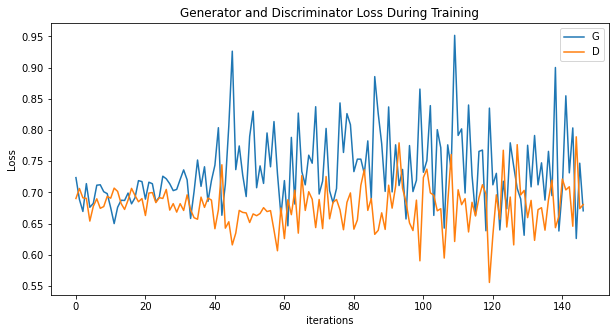

In [57]:
import matplotlib.pyplot as plt


# Plot losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_history,label="G")
plt.plot(d_loss_history,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


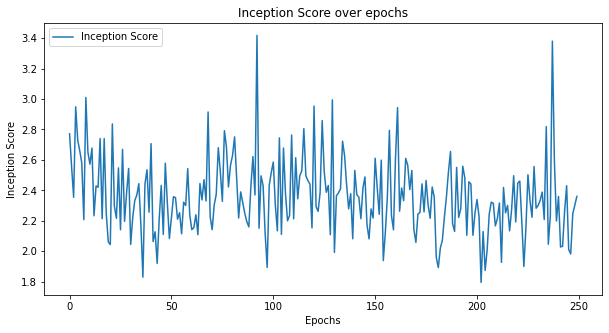

In [58]:
# IS history

plt.figure(figsize=(10,5))
plt.title("Inception Score over epochs")
plt.plot(is_history, label="Inception Score")
plt.xlabel("Epochs")
plt.ylabel("Inception Score")
plt.legend()
plt.show()

In [ ]:
#imgs.shape[0]

In [60]:
from cleanfid import fid

fdir1 = "images_celebA_DCGAN"
fdir2 = 'data/celebA/img_align_celeba/dummy'

celeba_fid_score = fid.compute_fid(fdir1, fdir2, dataset_res = 32)

compute FID between two folders
Found 250 images in the folder images_celebA_DCGAN


FID images_celebA_DCGAN : 100%|██████████| 8/8 [00:03<00:00,  2.18it/s]


Found 60000 images in the folder data/celebA/img_align_celeba/dummy


FID dummy : 100%|██████████| 1875/1875 [03:00<00:00, 10.36it/s]


In [63]:
celeba_fid_score

176.4752799058739